In [22]:
import os
import json
import scripts
import tensorflow as tf
import importlib

In [31]:
importlib.reload(scripts)

<module 'scripts' from '/Users/alfred/Documents/chinese_mnist_analysis/scripts.py'>

Disclaimer: contain directly copied or modified code from:
   1. ChatGPT (23 Mar)
   2. https://www.tensorflow.org/tutorials/images/transfer_learning
   3. https://www.kaggle.com/code/ateplyuk/mnist-efficientnet/notebook

# Solving Chinese MNIST using Transfer Learning

## Some Hyperparameters

In [3]:
NUMBER_OF_CLASSES = 15
IMAGE_SIZE = (64, 64)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

CLASSIFIER_LEARNING_RATE = 0.0001
CLASSIFIER_NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 32
OPTIMIZER = tf.keras.optimizers.Adam
LOSS_MEASURE = tf.keras.losses.SparseCategoricalCrossentropy

## Dataloaders

In [4]:
small_training_dataloader = tf.keras.utils.image_dataset_from_directory("./small_training_dataset/",
                                                                        batch_size=BATCH_SIZE,
                                                                        image_size=IMAGE_SIZE,
                                                                        seed=413)
medium_training_dataloader = tf.keras.utils.image_dataset_from_directory("./medium_training_dataset/",
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMAGE_SIZE,
                                                                         seed=413)
large_training_dataloader = tf.keras.utils.image_dataset_from_directory("./large_training_dataset/",
                                                                        batch_size=BATCH_SIZE,
                                                                        image_size=IMAGE_SIZE,
                                                                        seed=413)
validation_dataloader = tf.keras.utils.image_dataset_from_directory("./validation_dataset/",
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMAGE_SIZE,
                                                                    seed=413)

Found 1050 files belonging to 15 classes.


2023-04-19 17:37:30.489068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2100 files belonging to 15 classes.
Found 3150 files belonging to 15 classes.
Found 1050 files belonging to 15 classes.


### Take a Peek

Image batch shape = (32, 64, 64, 3)
Label batch shape = (32,)


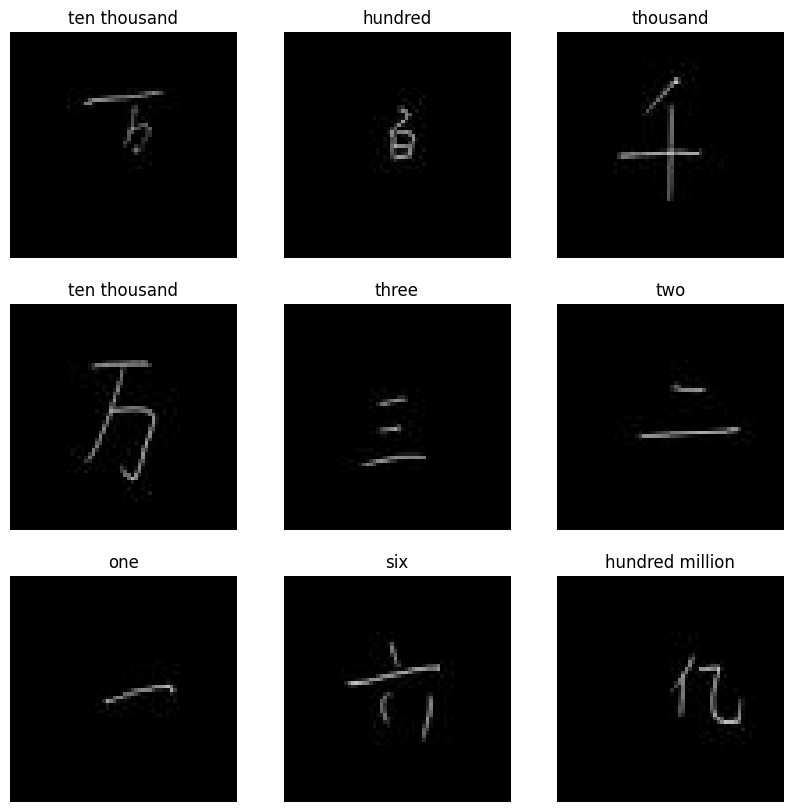

In [5]:
scripts.peek_into_dataloader(small_training_dataloader)

### Cache and Prefetch

In [6]:
small_training_dataloader = small_training_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
medium_training_dataloader = medium_training_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
large_training_dataloader = large_training_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataloader = validation_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Pre-Trained Base Models
The models expect inputs to be in the range [0, 255].

In [7]:
pretrained_efficientnet_to_fine_tune_with_small_dataset = tf.keras.applications.EfficientNetV2S(include_top=False, input_shape=IMAGE_SHAPE) 
pretrained_efficientnet_to_fine_tune_with_medium_dataset = tf.keras.applications.EfficientNetV2S(include_top=False, input_shape=IMAGE_SHAPE)
pretrained_efficientnet_to_fine_tune_with_large_dataset = tf.keras.applications.EfficientNetV2S(include_top=False, input_shape=IMAGE_SHAPE)

### Full Models
Adding our own classifiers.

In [8]:
pretrained_efficientnet_to_fine_tune_with_small_dataset = scripts.add_classifier(pretrained_efficientnet_to_fine_tune_with_small_dataset, IMAGE_SHAPE, NUMBER_OF_CLASSES)
pretrained_efficientnet_to_fine_tune_with_medium_dataset = scripts.add_classifier(pretrained_efficientnet_to_fine_tune_with_medium_dataset, IMAGE_SHAPE, NUMBER_OF_CLASSES)
pretrained_efficientnet_to_fine_tune_with_large_dataset = scripts.add_classifier(pretrained_efficientnet_to_fine_tune_with_large_dataset, IMAGE_SHAPE, NUMBER_OF_CLASSES)

### Inspection

In [9]:
print("Number of layers in the efficientnet base model: {}".format(len(pretrained_efficientnet_to_fine_tune_with_small_dataset.layers[1].layers)))

Number of layers in the efficientnet base model: 513


In [10]:
pretrained_efficientnet_to_fine_tune_with_small_dataset.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5243904   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 15)                15375     
                                                             

## Training the Classifiers

In [11]:
history_of_training_classifier_with_small_dataset = scripts.train_classifier(pretrained_efficientnet_to_fine_tune_with_small_dataset, 
                                                                             small_training_dataloader,
                                                                             validation_dataloader,
                                                                             CLASSIFIER_NUMBER_OF_EPOCHS,
                                                                             OPTIMIZER,
                                                                             CLASSIFIER_LEARNING_RATE,
                                                                             LOSS_MEASURE,
                                                                             True,
                                                                             ["accuracy"])

Number of trainable parameters before freezing the base model: 25436767
Number of trainable parameters after freezing the base model: 5259279
Epoch 1/10
33/33 [==============================] - 77s 1s/step - loss: 1.9421 - accuracy: 0.3895 - val_loss: 1.2182 - val_accuracy: 0.7019
Epoch 2/10
33/33 [==============================] - 42s 1s/step - loss: 0.9995 - accuracy: 0.7133 - val_loss: 0.8171 - val_accuracy: 0.8095
Epoch 3/10
33/33 [==============================] - 37s 1s/step - loss: 0.7145 - accuracy: 0.7867 - val_loss: 0.6435 - val_accuracy: 0.8371
Epoch 4/10
33/33 [==============================] - 32s 967ms/step - loss: 0.5991 - accuracy: 0.8210 - val_loss: 0.5710 - val_accuracy: 0.8410
Epoch 5/10
33/33 [==============================] - 30s 933ms/step - loss: 0.4988 - accuracy: 0.8619 - val_loss: 0.4925 - val_accuracy: 0.8733
Epoch 6/10
33/33 [==============================] - 34s 1s/step - loss: 0.4200 - accuracy: 0.8819 - val_loss: 0.4582 - val_accuracy: 0.8733
Epoch 7/10
3

In [12]:
history_of_training_classifier_with_medium_dataset = scripts.train_classifier(pretrained_efficientnet_to_fine_tune_with_medium_dataset, 
                                                                              medium_training_dataloader,
                                                                              validation_dataloader,
                                                                              CLASSIFIER_NUMBER_OF_EPOCHS,
                                                                              OPTIMIZER,
                                                                              CLASSIFIER_LEARNING_RATE,
                                                                              LOSS_MEASURE,
                                                                              True,
                                                                              ["accuracy"])

Number of trainable parameters before freezing the base model: 25436767
Number of trainable parameters after freezing the base model: 5259279
Epoch 1/10
66/66 [==============================] - 79s 861ms/step - loss: 1.4678 - accuracy: 0.5495 - val_loss: 0.7716 - val_accuracy: 0.8105
Epoch 2/10
66/66 [==============================] - 48s 732ms/step - loss: 0.6960 - accuracy: 0.7848 - val_loss: 0.5367 - val_accuracy: 0.8657
Epoch 3/10
66/66 [==============================] - 44s 663ms/step - loss: 0.5152 - accuracy: 0.8371 - val_loss: 0.4302 - val_accuracy: 0.8848
Epoch 4/10
66/66 [==============================] - 44s 662ms/step - loss: 0.4004 - accuracy: 0.8795 - val_loss: 0.3773 - val_accuracy: 0.8924
Epoch 5/10
66/66 [==============================] - 43s 651ms/step - loss: 0.3449 - accuracy: 0.8933 - val_loss: 0.3460 - val_accuracy: 0.9000
Epoch 6/10
66/66 [==============================] - 42s 637ms/step - loss: 0.2973 - accuracy: 0.9114 - val_loss: 0.3229 - val_accuracy: 0.8990


In [13]:
history_of_training_classifier_with_large_dataset = scripts.train_classifier(pretrained_efficientnet_to_fine_tune_with_large_dataset, 
                                                                             large_training_dataloader,
                                                                             validation_dataloader,
                                                                             CLASSIFIER_NUMBER_OF_EPOCHS,
                                                                             OPTIMIZER,
                                                                             CLASSIFIER_LEARNING_RATE,
                                                                             LOSS_MEASURE,
                                                                             True,
                                                                             ["accuracy"])

Number of trainable parameters before freezing the base model: 25436767
Number of trainable parameters after freezing the base model: 5259279
Epoch 1/10
99/99 [==============================] - 77s 583ms/step - loss: 1.3076 - accuracy: 0.6016 - val_loss: 0.6536 - val_accuracy: 0.8133
Epoch 2/10
99/99 [==============================] - 55s 552ms/step - loss: 0.5984 - accuracy: 0.8083 - val_loss: 0.4509 - val_accuracy: 0.8676
Epoch 3/10
99/99 [==============================] - 54s 548ms/step - loss: 0.4473 - accuracy: 0.8559 - val_loss: 0.3654 - val_accuracy: 0.8933
Epoch 4/10
99/99 [==============================] - 55s 552ms/step - loss: 0.3522 - accuracy: 0.8895 - val_loss: 0.3090 - val_accuracy: 0.9105
Epoch 5/10
99/99 [==============================] - 52s 523ms/step - loss: 0.2993 - accuracy: 0.9076 - val_loss: 0.2845 - val_accuracy: 0.9124
Epoch 6/10
99/99 [==============================] - 48s 491ms/step - loss: 0.2563 - accuracy: 0.9225 - val_loss: 0.2562 - val_accuracy: 0.9257


## Fine-Tuning the Entire Models

Only fine tune after the classifier have been trained.

### Some Hyperparameters

In [14]:
FINE_TUNING_LEARNING_RATE = CLASSIFIER_LEARNING_RATE / 10
FINE_TUNING_NUMBER_OF_EPOCHS = 10
TOTAL_NUMBER_OF_EPOCHS = CLASSIFIER_NUMBER_OF_EPOCHS + FINE_TUNING_NUMBER_OF_EPOCHS
NUMBER_OF_LAYERS_TO_FREEZE = 100

In [15]:
history_of_fine_tuning_with_small_dataset = scripts.fine_tune(pretrained_efficientnet_to_fine_tune_with_small_dataset,
                                                              NUMBER_OF_LAYERS_TO_FREEZE,
                                                              history_of_training_classifier_with_small_dataset,
                                                              small_training_dataloader,
                                                              validation_dataloader,
                                                              TOTAL_NUMBER_OF_EPOCHS,
                                                              OPTIMIZER,
                                                              FINE_TUNING_LEARNING_RATE,
                                                              LOSS_MEASURE,
                                                              True,
                                                              ["accuracy"])

Number of trainable parameters after unfreezing the entire base model: 25436767
Number of trainable parameters after freezing the first 100 layers of the base model: 24228183
Epoch 10/20
33/33 [==============================] - 116s 2s/step - loss: 0.1807 - accuracy: 0.9486 - val_loss: 0.2761 - val_accuracy: 0.9124
Epoch 11/20
33/33 [==============================] - 60s 2s/step - loss: 0.1392 - accuracy: 0.9571 - val_loss: 0.2610 - val_accuracy: 0.9162
Epoch 12/20
33/33 [==============================] - 59s 2s/step - loss: 0.0938 - accuracy: 0.9752 - val_loss: 0.2441 - val_accuracy: 0.9143
Epoch 13/20
33/33 [==============================] - 58s 2s/step - loss: 0.0743 - accuracy: 0.9810 - val_loss: 0.2352 - val_accuracy: 0.9124
Epoch 14/20
33/33 [==============================] - 59s 2s/step - loss: 0.0522 - accuracy: 0.9914 - val_loss: 0.2261 - val_accuracy: 0.9190
Epoch 15/20
33/33 [==============================] - 60s 2s/step - loss: 0.0491 - accuracy: 0.9895 - val_loss: 0.2390 -

In [16]:
history_of_fine_tuning_with_medium_dataset = scripts.fine_tune(pretrained_efficientnet_to_fine_tune_with_medium_dataset,
                                                               NUMBER_OF_LAYERS_TO_FREEZE,
                                                               history_of_training_classifier_with_medium_dataset,
                                                               medium_training_dataloader,
                                                               validation_dataloader,
                                                               TOTAL_NUMBER_OF_EPOCHS,
                                                               OPTIMIZER,
                                                               FINE_TUNING_LEARNING_RATE,
                                                               LOSS_MEASURE,
                                                               True,
                                                               ["accuracy"])

Number of trainable parameters after unfreezing the entire base model: 25436767
Number of trainable parameters after freezing the first 100 layers of the base model: 24228183
Epoch 10/20
66/66 [==============================] - 168s 2s/step - loss: 0.1291 - accuracy: 0.9605 - val_loss: 0.1951 - val_accuracy: 0.9343
Epoch 11/20
66/66 [==============================] - 111s 2s/step - loss: 0.0950 - accuracy: 0.9695 - val_loss: 0.1815 - val_accuracy: 0.9390
Epoch 12/20
66/66 [==============================] - 110s 2s/step - loss: 0.0703 - accuracy: 0.9805 - val_loss: 0.1672 - val_accuracy: 0.9438
Epoch 13/20
66/66 [==============================] - 103s 2s/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0.1624 - val_accuracy: 0.9495
Epoch 14/20
66/66 [==============================] - 103s 2s/step - loss: 0.0422 - accuracy: 0.9886 - val_loss: 0.1690 - val_accuracy: 0.9371
Epoch 15/20
66/66 [==============================] - 104s 2s/step - loss: 0.0327 - accuracy: 0.9924 - val_loss: 0.1

In [17]:
history_of_fine_tuning_with_large_dataset = scripts.fine_tune(pretrained_efficientnet_to_fine_tune_with_large_dataset,
                                                              NUMBER_OF_LAYERS_TO_FREEZE,
                                                              history_of_training_classifier_with_large_dataset,
                                                              large_training_dataloader,
                                                              validation_dataloader,
                                                              TOTAL_NUMBER_OF_EPOCHS,
                                                              OPTIMIZER,
                                                              FINE_TUNING_LEARNING_RATE,
                                                              LOSS_MEASURE,
                                                              True,
                                                              ["accuracy"])

Number of trainable parameters after unfreezing the entire base model: 25436767
Number of trainable parameters after freezing the first 100 layers of the base model: 24228183
Epoch 10/20
99/99 [==============================] - 223s 2s/step - loss: 0.1276 - accuracy: 0.9575 - val_loss: 0.1576 - val_accuracy: 0.9562
Epoch 11/20
99/99 [==============================] - 158s 2s/step - loss: 0.0808 - accuracy: 0.9768 - val_loss: 0.1423 - val_accuracy: 0.9581
Epoch 12/20
99/99 [==============================] - 154s 2s/step - loss: 0.0534 - accuracy: 0.9851 - val_loss: 0.1443 - val_accuracy: 0.9581
Epoch 13/20
99/99 [==============================] - 152s 2s/step - loss: 0.0456 - accuracy: 0.9867 - val_loss: 0.1362 - val_accuracy: 0.9610
Epoch 14/20
99/99 [==============================] - 201s 2s/step - loss: 0.0311 - accuracy: 0.9921 - val_loss: 0.1395 - val_accuracy: 0.9600
Epoch 15/20
99/99 [==============================] - 201s 2s/step - loss: 0.0239 - accuracy: 0.9959 - val_loss: 0.1

## Save Models

In [19]:
SAVED_MODEL_DIRECTORY = "./saved_models"
pretrained_efficientnet_to_fine_tune_with_small_dataset.save(os.path.join(SAVED_MODEL_DIRECTORY, "pretrained_efficientnet_fine_tuned_with_small_dataset"))
pretrained_efficientnet_to_fine_tune_with_medium_dataset.save(os.path.join(SAVED_MODEL_DIRECTORY, "pretrained_efficientnet_fine_tuned_with_medium_dataset"))
pretrained_efficientnet_to_fine_tune_with_large_dataset.save(os.path.join(SAVED_MODEL_DIRECTORY, "pretrained_efficientnet_fine_tuned_with_large_dataset"))

INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_small_dataset/assets


INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_small_dataset/assets


INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_medium_dataset/assets


INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_medium_dataset/assets


INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_large_dataset/assets


INFO:tensorflow:Assets written to: ./saved_models/pretrained_efficientnet_fine_tuned_with_large_dataset/assets


## Save Histories

In [24]:
SAVED_HISTORIES_DIRECTORY = "./saved_histories"
with open(os.path.join(SAVED_HISTORIES_DIRECTORY, "history_of_fine_tuning_with_small_dataset.json"), "w") as file:
    json.dump(history_of_fine_tuning_with_small_dataset.history, file)

with open(os.path.join(SAVED_HISTORIES_DIRECTORY, "history_of_fine_tuning_with_medium_dataset.json"), "w") as file:
    json.dump(history_of_fine_tuning_with_medium_dataset.history, file)

with open(os.path.join(SAVED_HISTORIES_DIRECTORY, "history_of_fine_tuning_with_large_dataset.json"), "w") as file:
    json.dump(history_of_fine_tuning_with_large_dataset.history, file)

## Results

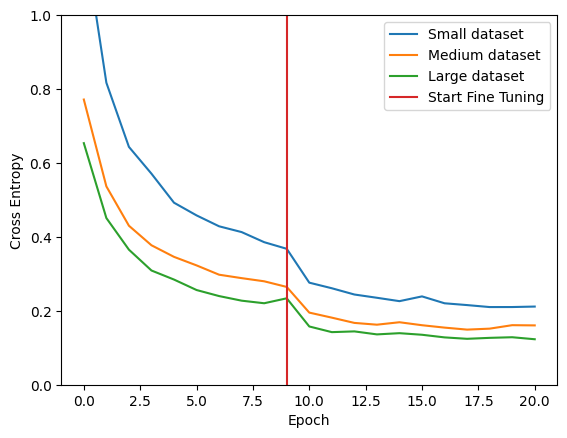

In [32]:
scripts.validation_losses_of_all_models_after_fine_tuning([history_of_training_classifier_with_small_dataset, history_of_training_classifier_with_medium_dataset, history_of_training_classifier_with_large_dataset],
                                                          [history_of_fine_tuning_with_small_dataset, history_of_fine_tuning_with_medium_dataset, history_of_fine_tuning_with_large_dataset],
                                                          ["Small dataset", "Medium dataset", "Large dataset"],
                                                          CLASSIFIER_NUMBER_OF_EPOCHS,
                                                          "Validation Loss of Pre-Trained EfficientNet Fine-Tuned on Dataset of Various Sizes")

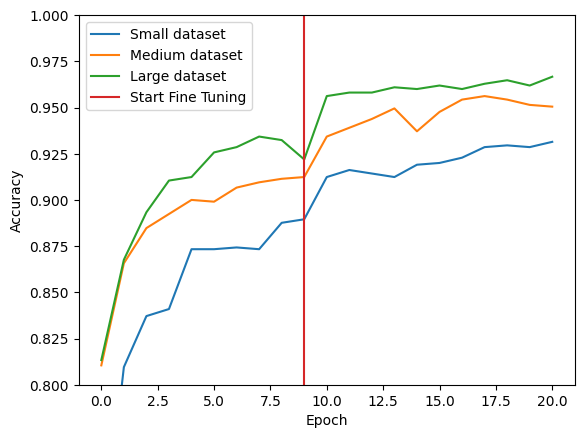

In [33]:
scripts.validation_accuracies_of_all_models_after_fine_tuning([history_of_training_classifier_with_small_dataset, history_of_training_classifier_with_medium_dataset, history_of_training_classifier_with_large_dataset],
                                                              [history_of_fine_tuning_with_small_dataset, history_of_fine_tuning_with_medium_dataset, history_of_fine_tuning_with_large_dataset],
                                                              ["Small dataset", "Medium dataset", "Large dataset"],
                                                              CLASSIFIER_NUMBER_OF_EPOCHS,
                                                              "Validation Accuracy of Pre-Trained EfficientNet Fine-Tuned on Dataset of Various Sizes")